# Ellipse Example

### Settings
- **Prior**: Uniform on $\mathcal{U}([-10, 10]\times [-10, 10])$
- **Manifold**: Ellipse corresponding to $\mathcal{M} = \{x\in\mathbb{R}^2\,:\, f(x) = 0\}$ where $f(x) = \log \mathcal{N}(x \mid 0, \Sigma) - z_0$ where $\Sigma = \text{diag}(1.0, 0.1)$ and $z_0 = 0.04$.
- **Kernel**: Uniform
- **Target Posterior**: 
$$
\eta_\epsilon(x) \propto \mathbb{I}_{f^{-1}(\mathbb{B}(z_0, \epsilon))}(x)
$$

### Aim and Scope
- Pick a good $\epsilon$
- Pick a good $\delta$
- For a range of $\alpha$s compute $\Delta_\ell$ and $\Delta_v$ and plot histograms for each $\alpha$.


In [563]:
import numpy as np
from numpy import zeros, eye, diag, exp, log
from numpy.linalg import norm, solve
from numpy.random import randn, rand
from scipy.stats import multivariate_normal as MVN
from scipy.stats import uniform as udist
from scipy.stats import norm as ndist
from itertools import product
from IPython.display import display

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

from Manifolds.GeneralizedEllipse import GeneralizedEllipse
from utils import prep_contour, generate_powers_of_ten, line_between

### Functions and Setup

In [258]:
# Manifold
μ       = zeros(2)
Σ       = diag([1, 0.1])
target  = MVN(μ, Σ)
f = target.logpdf
z0      = -2.9513586307684885                # Specifies exactly which ellipse we are interested in (y*).
ellipse = GeneralizedEllipse(μ, Σ, exp(z0))

# Gradient function
grad  = lambda xi: -solve(Σ, xi - μ)
q = MVN(zeros(2), eye(2))

# Prior function is uniform on a huge square
square_side = 10  # SQUARE SIDE
logprior  = lambda xi: udist.logpdf(xi, loc=-square_side, scale=2*square_side).sum()
# logprior  = lambda xi: ndist.logpdf(xi, loc=0.0, scale=2.0).sum()

def generate_logpi(ϵ):
    # Kernel
#     def logkernel(xi):
#         with np.errstate(divide='ignore'):
#             return log(float(norm(f(xi) - z0) < ϵ) / ϵ)
    def logkernel(xi):
        return -norm(f(xi) - z0)**2/(2*(ϵ**2)) - np.log(ϵ)
    # Logpi
    logpi = lambda xi: logprior(xi) + logkernel(xi)
    return logpi

In [259]:
def HugTangential(x0, δ, B, N, α, q, logpi, grad_log_pi):
    """
    Repurposed version of THUG.
    """
    # The following dictionary stores everything we need
    OUT = {
        'D' : {f"{i}": [] for i in range(N)}, # Distance
        'SD': {f"{i}": [] for i in range(N)}, # Square Distance
        'AR': [np.nan for i in range(N)],     # Acceptance Ratio
        'Δk': [np.nan for i in range(N)],     # Kinetic Energy
        'Δℓ': [np.nan for i in range(N)],     # Potential Energy
        'SAMPLES': x0,
        'ACCEPTANCES': np.zeros(N),
        'EJSD': [np.nan for i in range(N)]    # Acceptance Ratio * Squared Distance
    }
    for i in range(N):
        v0s = q.rvs()                    # Draw velocity spherically
        g = grad_log_pi(x0)              # Compute gradient at x0
        g = g / norm(g)                  # Normalize
        v0 = v0s - α * g * (g @ v0s) # Tilt velocity
        v, x = v0, x0                    # Housekeeping
        logu = np.log(rand())            # Acceptance ratio
        for _ in range(B):
            xmid = x + δ*v/2           # Move to midpoint
            g = grad_log_pi(xmid)          # Compute gradient at midpoint
            ghat = g / norm(g)          # Normalize 
            v = v - 2*(v @ ghat) * ghat # Reflect velocity using midpoint gradient
            x = xmid + δ*v/2           # Move from midpoint to end-point
            # Compute metrics
            OUT['D'][f"{i}"].append(norm(x - x0))
            OUT['SD'][f"{i}"].append(norm(x  -x0)**2)

        # Unsqueeze the velocity
        g = grad_log_pi(x)
        g = g / norm(g)
        v = v + (α / (1 - α)) * g * (g @ v)
        # In the acceptance ratio must use spherical velocities!! Hence v0s and the unsqueezed v
        logar = logpi(x) + q.logpdf(v) - logpi(x0) - q.logpdf(v0s)
        ar = exp(logar)
        OUT['AR'][i] = ar
        OUT['Δk'][i] = - norm(v)**2 + norm(v0s)**2
        OUT['Δℓ'][i] = logpi(x) - logpi(x0)
        OUT['EJSD'][i] = ar * (norm(x - x0)**2)
        if logu <= logar:
            OUT['SAMPLES'] = np.vstack((OUT['SAMPLES'], x))
            OUT['ACCEPTANCES'][i] = 1         # Accepted!
            x0 = x
        else:
            OUT['SAMPLES'] = np.vstack((OUT['SAMPLES'], x0))
            OUT['ACCEPTANCES'][i] = 0         # Rejected
    return OUT

In [260]:
def generate_output(ϵs, αs, δs):
    OUTS = []
    for ϵix, ϵ in enumerate(ϵs):
        for αix, α in enumerate(αs):
            for δix, δ in enumerate(δs):
                x0 = ellipse.sample()
                logpi = generate_logpi(ϵ)
                OUTS.append(HugTangential(x0, δ, B, N, α, q, logpi, grad))
    return OUTS

In [261]:
# Settings
ϵ = 0.001
δ = 0.1
B = 20
N = 10000

In [262]:
ϵs = [ϵ]
δs = [δ]
αs = [0.0, 0.5, 0.9, 0.99]

In [263]:
OUTS = generate_output(
    ϵs=ϵs,
    αs=αs,
    δs=δs
)

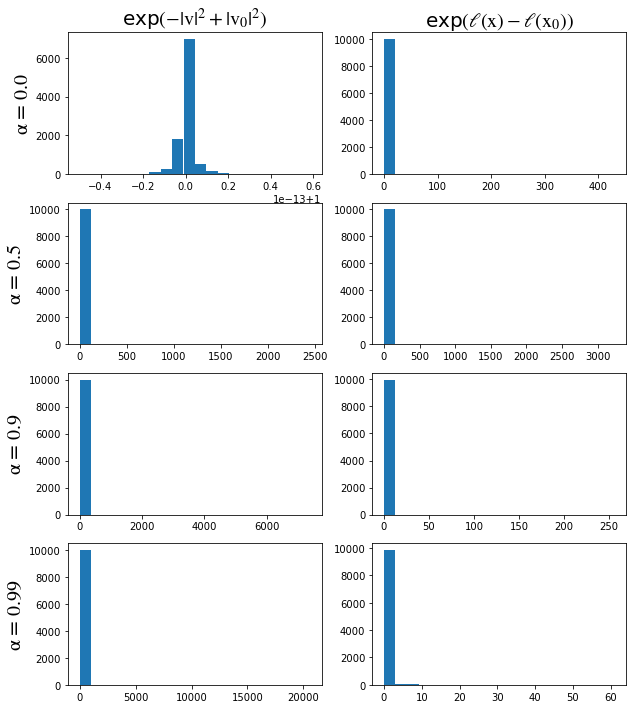

In [264]:
fig, ax = plt.subplots(nrows=len(αs), ncols=2, figsize=(10, int(3*len(αs))))
for α_ix, α in enumerate(αs):
    _ = ax[α_ix, 0].hist(np.exp(OUTS[α_ix]['Δk']), bins=20)
    _ = ax[α_ix, 1].hist(np.exp(OUTS[α_ix]['Δℓ']), bins=20)
    ax[α_ix, 0].set_ylabel(r"$\mathregular{\alpha}=$" + f"{α}", fontsize=20, fontname='STIXGeneral')
ax[0, 0].set_title(r"$\mathregular{\exp(- \|v\|^2 + \|v_0\|^2)}$", fontsize=20, fontname='STIXGeneral')
ax[0, 1].set_title(r"$\mathregular{\exp(\ell(x) - \ell(x_0))}$", fontsize=20, fontname='STIXGeneral')
plt.show()

In [265]:
from matplotlib.colors import ListedColormap

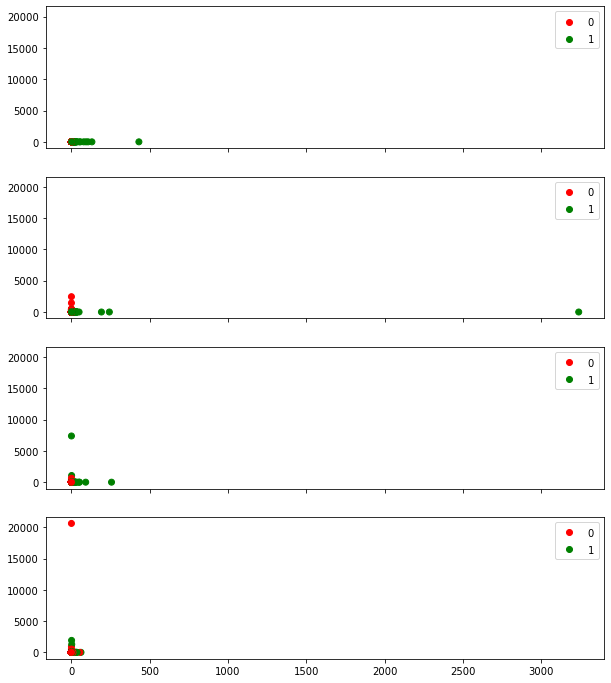

In [266]:
fig, ax = plt.subplots(nrows=len(αs), figsize=(10, int(3*len(αs))), sharey=True, sharex=True)
for α_ix, α in enumerate(αs):
    scatter = ax[α_ix].scatter(np.exp(OUTS[α_ix]['Δℓ']), np.exp(OUTS[α_ix]['Δk']), c=OUTS[α_ix]['ACCEPTANCES'], cmap=ListedColormap(['r','b','g']))
#     plt.legend(handles=scatter.legend_elements()[0], labels=[1, 0],
#            title="ar")
    ax[α_ix].legend(*scatter.legend_elements())
# ax[-1].set_ylim(-0.1, 10)
# ax[-1].set_xlim(-0.1, 100)
# ax[0, 0].set_title(r"$\mathregular{\exp(- \|v\|^2 + \|v_0\|^2)}$", fontsize=20, fontname='STIXGeneral')
# ax[0, 1].set_title(r"$\mathregular{\exp(\ell(x) - \ell(x_0))}$", fontsize=20, fontname='STIXGeneral')
plt.show()

In [182]:
np.median(OUTS[1]['Δk']), np.median(OUTS[2]['Δk']), np.median(OUTS[3]['Δk'])

(-0.009133115768229685, -0.045143802242102765, -0.19769407137004202)

In [183]:
np.median(OUTS[1]['Δℓ']), np.median(OUTS[2]['Δℓ']), np.median(OUTS[3]['Δℓ'])

(-1.489892817614745, -0.19932308202615, -0.16009950716028154)

In [186]:
np.median(np.exp(OUTS[0]['Δk'])), np.median(np.exp(OUTS[1]['Δk'])), np.median(np.exp(OUTS[2]['Δk'])), np.median(np.exp(OUTS[3]['Δk']))

(1.0, 0.9909084650275177, 0.9558600690690136, 0.8206208793386524)

In [187]:
np.median(np.exp(OUTS[0]['Δℓ'])), np.median(np.exp(OUTS[1]['Δℓ'])), np.median(np.exp(OUTS[2]['Δℓ'])), np.median(np.exp(OUTS[3]['Δℓ']))

(0.0066305657409287564,
 0.22539809424972396,
 0.8192851544978443,
 0.8520597647944054)

In [188]:
np.median(np.exp(OUTS[0]['AR'])), np.median(np.exp(OUTS[1]['AR'])), np.median(np.exp(OUTS[2]['AR'])), np.median(np.exp(OUTS[3]['AR']))

(1.006652596632966, 1.2113270821947866, 1.754840709560584, 1.7417990464149518)

In [191]:
np.array([np.median(np.exp(OUTS[0]['Δk'])), np.median(np.exp(OUTS[1]['Δk'])), np.median(np.exp(OUTS[2]['Δk'])), np.median(np.exp(OUTS[3]['Δk']))])

array([1.        , 0.99090847, 0.95586007, 0.82062088])

In [192]:
np.array([np.median(np.exp(OUTS[0]['Δℓ'])), np.median(np.exp(OUTS[1]['Δℓ'])), np.median(np.exp(OUTS[2]['Δℓ'])), np.median(np.exp(OUTS[3]['Δℓ']))])

array([0.00663057, 0.22539809, 0.81928515, 0.85205976])

In [193]:
np.array([np.median(np.exp(OUTS[0]['Δk'])), np.median(np.exp(OUTS[1]['Δk'])), np.median(np.exp(OUTS[2]['Δk'])), np.median(np.exp(OUTS[3]['Δk']))]) * np.array([np.median(np.exp(OUTS[0]['Δℓ'])), np.median(np.exp(OUTS[1]['Δℓ'])), np.median(np.exp(OUTS[2]['Δℓ'])), np.median(np.exp(OUTS[3]['Δℓ']))]) 

array([0.00663057, 0.22334888, 0.78312196, 0.69921803])

In [194]:
OUTS[0]['AR'][0]

0.7646226203723631

In [196]:
exp(OUTS[0]['Δk'][0]) * exp(OUTS[0]['Δℓ'][0])

0.7646226203723632

# Moving Interval

In [267]:
def percentage_in_interval(iterable, left, right):
    """Counts the number of elements in `iterable` that are contained in the 
    interval `[left, right]`."""
    array = np.array(iterable)
    flag = (left <= array) & (array <= right)
    return (len(array[flag]) / len(array)) * 100

def prop_to_quantile_interval(p):
    """Transforms a proportion `p` into a quantile interval."""
    assert (0 <= p) and (p <= 1), "Proportion must be between 0 and 1."
    slack = (1.0 - p) / 2
    return np.array([slack, 1.0 - slack])

def generate_Δℓ_table(outs, props):
    table = zeros((len(outs), len(props)))
    for p_ix, p in enumerate(props):
        # Transform `p` into a quantile interval
        q_interval = prop_to_quantile_interval(p)
        # Find interval within which for α=0 we get p% of Δℓ in
        left, right = np.quantile(a=outs[0]['Δℓ'], q=q_interval)
        # Fill in the first row of the table
        table[0, p_ix] = percentage_in_interval(outs[0]['Δℓ'], left, right) # should be p
        # Fill in the rest of the rows for other αs
        for α_ix in range(1, len(outs)):
            table[α_ix, p_ix] = percentage_in_interval(outs[α_ix]['Δℓ'], left, right)
    return table

In [273]:
generate_Δℓ_table(OUTS, [0.25, 0.5, 0.75, 0.9])

array([[25.  , 50.  , 75.  , 90.  ],
       [26.72, 52.29, 79.65, 92.54],
       [20.47, 42.36, 79.74, 92.7 ],
       [19.77, 41.48, 80.42, 93.46]])

In [438]:
def proportion_lessthan(iterable, value):
    """Proportion of elements in iterable that are less than value."""
    array = np.array(iterable)
    flag = array <= value
    return (sum(flag) / len(array))

In [586]:
def find_value_so_prop_Δℓ_larger(iterable, p, tol=0.01):
    """Finds a value L such that the proportion of samples with Δℓ in [L, \infty) is p."""
    assert (0 <= p) & (p <= 1), "Must be between 0 and 1."
    array, sorted_array = np.array(iterable), np.sort(np.array(iterable))
    iteration = 0
    N = len(array)
    # Start with N*(1-p) as an index
    L = sorted_array[int(np.floor(N*(1-p)))]
    is_prop_lessthan_within_tol_of_1_minus_p = lambda L: abs(proportion_lessthan(array, L) - (1 - p)) <= tol
    while is_prop_lessthan_within_tol_of_1_minus_p(L) and (iteration < len(array) - 1):
        iteration += 1
        L = sorted_array[iteration]
    return L

def generate_Δℓ_table_new(outs, props):
    """This table only works on intervals of the type [L, \infty)."""
    table = zeros((len(outs), len(props)))
    Ls = []
    for p_ix, p in enumerate(props):
        # Find value L so that a proportion p of samples have Δℓ larger than L
        L = find_value_so_prop_Δℓ_larger_new(outs[0]['Δℓ'], p)
        Ls.append(L)
        # Fill in the first row of the table
        table[0, p_ix] = percentage_in_interval(outs[0]['Δℓ'], L, np.inf) # should be p
        # Fill in the rest of the rows for other αs
        for α_ix in range(1, len(outs)):
            table[α_ix, p_ix] = percentage_in_interval(outs[α_ix]['Δℓ'], L, np.inf)
    return table, Ls

In [454]:
def find_value_so_prop_Δℓ_larger_new(iterable, p):
    N = len(iterable)
    
    return np.sort(np.array(iterable))[int(np.floor(N*np.round(1-p, decimals=2)))]

In [587]:
generate_Δℓ_table_new(OUTS, [0.25, 0.5, 0.75, 0.9])

(array([[25.  , 50.  , 75.  , 90.  ],
        [33.7 , 62.12, 86.08, 95.81],
        [46.32, 72.34, 88.74, 96.55],
        [46.11, 71.69, 87.7 , 96.08]]),
 [-0.13699149960447876,
  -4.417695950583556,
  -40.638261376772235,
  -217.21936170409748])

In [588]:
def generate_latex_table(table, Ls):
    """Generate table."""
    s  = r"\begin{table}[htp]"         + "\n"
    s += r"\begin{tabular}{l|llll}"    + "\n"
    s += r"& $\Delta\ell \geq {:.2f}$ & $\Delta\ell \geq {:.2f}$ & $\Delta\ell \geq {:.2f}$ & $\Delta\ell \geq {:.2f}$ \\ \hline".format(*Ls) + "\n"
    s += r"$\alpha = 0$    & {:.0f} & {:.0f} & {:.0f} & {:.0f} \\".format(*table[0, :]) + "\n"
    s += r"$\alpha = 0.5$  & {:.2f} & {:.2f} & {:.2f} & {:.2f} \\".format(*table[1, :]) + "\n"
    s += r"$\alpha = 0.9$  & {:.2f} & {:.2f} & {:.2f} & {:.2f} \\".format(*table[2, :]) + "\n"
    s += r"$\alpha = 0.99$ & {:.2f} & {:.2f} & {:.2f} & {:.2f}".format(*table[3, :]) + "\n"
    s += r"\end{tabular}" + "\n"
    s += r"\end{table}"
    print(s)

In [589]:
generate_latex_table(*generate_Δℓ_table_new(OUTS, [0.25, 0.5, 0.75, 0.9]))

\begin{table}[htp]
\begin{tabular}{l|llll}
& $\Delta\ell \geq -0.14$ & $\Delta\ell \geq -4.42$ & $\Delta\ell \geq -40.64$ & $\Delta\ell \geq -217.22$ \\ \hline
$\alpha = 0$    & 25 & 50 & 75 & 90 \\
$\alpha = 0.5$  & 33.70 & 62.12 & 86.08 & 95.81 \\
$\alpha = 0.9$  & 46.32 & 72.34 & 88.74 & 96.55 \\
$\alpha = 0.99$ & 46.11 & 71.69 & 87.70 & 96.08
\end{tabular}
\end{table}


### Relationship between $\Delta \ell$ and $\Delta k$

In [511]:
α_index = 3
k_prop = 0.9
K = find_value_so_prop_Δℓ_larger_new(OUTS[α_index]['Δk'], k_prop)
less_than_K_flag = np.array(OUTS[α_index]['Δk']) <= K
with np.printoptions(precision=2, suppress=True):
    display(np.quantile(np.array(OUTS[α_index]['Δℓ'])[less_than_K_flag], q=[0.0, 0.25, 0.5, 0.75, 0.9]))
    display(np.quantile(np.array(OUTS[α_index]['Δℓ'])[~less_than_K_flag], q=[0.0, 0.25, 0.5, 0.75, 0.9]))

array([-8480.52,  -270.1 ,   -65.28,    -5.06,    -0.19])

array([-3195.09,    -3.47,    -0.13,     0.  ,     0.15])

### Connecting $\Delta \ell$ and $\Delta k$

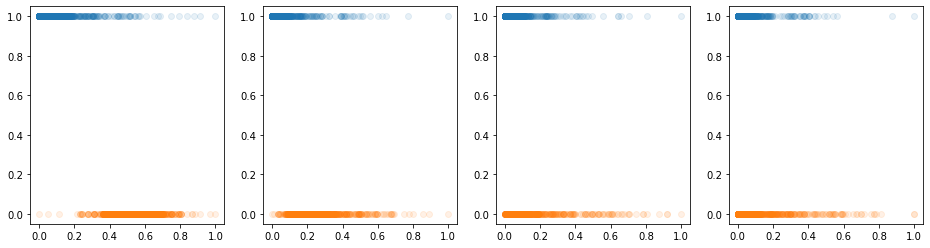

In [554]:
def transform(x):
    """Inverse of the min-max normalization (max-min normalization), so that we invert the signs."""
    xmax, xmin = np.max(x), np.min(x)
    return (x - xmax) / (xmin - xmax)

    
fig, ax = plt.subplots(ncols=len(αs), figsize=(4*len(αs), 4))
for α_ix, α in enumerate(αs):
    ax[α_ix].scatter(*np.vstack((transform(OUTS[α_ix]['Δℓ']), np.ones(N))), alpha=0.1)
    ax[α_ix].scatter(*np.vstack((transform(OUTS[α_ix]['Δk']), np.zeros(N))), alpha=0.1)

In [558]:
DELTA_L = np.vstack((transform(OUTS[0]['Δℓ']), np.ones(N)))
DELTA_K = np.vstack((transform(OUTS[0]['Δk']), np.zeros(N)))

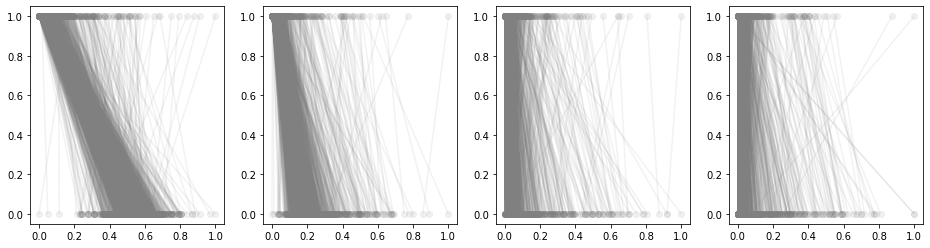

In [578]:
fig, ax = plt.subplots(ncols=len(αs), figsize=(4*len(αs), 4))
for α_ix, α in enumerate(αs):
    for i in range(N):
        ax[α_ix].plot(*line_between(
            np.vstack((transform(OUTS[α_ix]['Δℓ']), np.ones(N)))[:, i], 
            np.vstack((transform(OUTS[α_ix]['Δk']), np.zeros(N)))[:, i]), marker='o', c='gray', alpha=0.1)

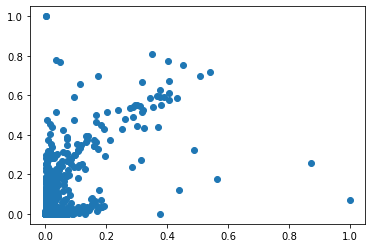

In [580]:
plt.scatter(transform(OUTS[α_ix]['Δℓ']), transform(OUTS[α_ix]['Δk']))